In [1]:
import warnings

import torch

from dataset import PIDJSONDataset, get_dataloaders
from trainer import Trainer
from utils import plot_training_curves
from wrapper import Wrapper

warnings.filterwarnings("ignore")

In [2]:
device = (
    torch.device("cuda")
    if torch.cuda.is_available()
    else torch.device("mps")
    if torch.backends.mps.is_available()
    else torch.device("cpu")
)
IMAGES_DIR = "dataset/images"
ANN_DIR = "dataset/annotations"
# ---------------- Configuration ----------------
config = {
    "batch_size": 6,
    "epochs": 10,
    "learning_rate": 0.001,
    "train_split": 0.8,
    "val_split": 0.1,
    "test_split": 0.1,
    "iou_threshold": 0.5,
    "confidence_threshold": 0.25,
}

In [3]:
train_loader, val_loader, test_loader = get_dataloaders(
    batch_size=config["batch_size"],
    train_split=config["train_split"],
    val_split=config["val_split"],
    num_workers=4,
    images_dir=IMAGES_DIR,
    ann_dir=ANN_DIR,
    symbol_mode='unified',
)

Found 500 annotation files
Loaded 500 diagrams
Mode: unified
Classes: ['background', 'symbol', 'word', 'line'] (4)
Splits - Train: 400, Val: 50, Test: 50


In [4]:
dataset = PIDJSONDataset(
    images_dir=IMAGES_DIR,
    ann_dir=ANN_DIR,
    symbol_mode='unified'
)
num_classes = len(dataset.class_names)  # background + word + line + symbols


Found 500 annotation files
Loaded 500 diagrams
Mode: unified
Classes: ['background', 'symbol', 'word', 'line'] (4)


In [5]:
# Create model wrapper
wrapper = Wrapper(device=device, num_classes=num_classes)

# ---------------- Trainer ----------------
trainer = Trainer(wrapper, device=device, lr=config["learning_rate"])

In [ ]:
trainer.train(train_loader, val_loader=val_loader, epochs=config["epochs"])

Training on cuda for 10 epochs

Epoch 1/10


Epoch 1: 100%|██████████| 67/67 [01:17<00:00,  1.16s/it, loss=1.4914]


Model saved to: models/best_model.pth
Saved new best model with val loss 1.5086
Train Loss: 1.9736, Val Loss: 1.5086

Epoch 2/10


Epoch 2: 100%|██████████| 67/67 [01:20<00:00,  1.20s/it, loss=1.3467]


Model saved to: models/best_model.pth
Saved new best model with val loss 1.3044
Train Loss: 1.4315, Val Loss: 1.3044

Epoch 3/10


Epoch 3: 100%|██████████| 67/67 [01:16<00:00,  1.14s/it, loss=1.2043]


Model saved to: models/best_model.pth
Saved new best model with val loss 1.1992
Train Loss: 1.2663, Val Loss: 1.1992

Epoch 4/10


Epoch 4: 100%|██████████| 67/67 [01:15<00:00,  1.13s/it, loss=1.1571]


Model saved to: models/best_model.pth
Saved new best model with val loss 1.1549
Train Loss: 1.1859, Val Loss: 1.1549

Epoch 5/10


Epoch 5: 100%|██████████| 67/67 [01:18<00:00,  1.17s/it, loss=1.2113]


Train Loss: 1.1724, Val Loss: 1.1549

Epoch 6/10


Epoch 6: 100%|██████████| 67/67 [01:18<00:00,  1.17s/it, loss=1.1661]


Model saved to: models/best_model.pth
Saved new best model with val loss 1.1476
Train Loss: 1.1648, Val Loss: 1.1476

Epoch 7/10


Epoch 7: 100%|██████████| 67/67 [01:19<00:00,  1.18s/it, loss=1.2129]


Model saved to: models/best_model.pth
Saved new best model with val loss 1.1414
Train Loss: 1.1518, Val Loss: 1.1414

Epoch 8/10


Epoch 8: 100%|██████████| 67/67 [01:14<00:00,  1.11s/it, loss=1.0555]


Train Loss: 1.1514, Val Loss: 1.1465

Epoch 9/10


Epoch 9: 100%|██████████| 67/67 [01:14<00:00,  1.11s/it, loss=1.1561]


Train Loss: 1.1500, Val Loss: 1.1673

Epoch 10/10


Epoch 10: 100%|██████████| 67/67 [01:24<00:00,  1.26s/it, loss=1.1998]


In [11]:
metrics = trainer.evaluate(
    test_loader,
    iou_threshold=config["iou_threshold"],
    confidence_threshold=config["confidence_threshold"],
    class_names=dataset.class_names,
)

print("\n=== FINAL RESULTS ===")
print(f"mAP (mean Average Precision): {metrics['mAP']:.4f}")
print(f"Mean IoU: {metrics['mean_iou']:.4f}")
print(f"Mean Precision: {metrics['mean_precision']:.4f}")
print(f"Mean Recall: {metrics['mean_recall']:.4f}")
print(f"Mean F1-Score: {metrics['mean_f1']:.4f}")
print(f"Average Inference Time: {metrics['avg_inference_time']:.4f} sec/image")

Evaluating model...


Evaluating: 100%|██████████| 9/9 [00:18<00:00,  2.03s/it]


symbol - Precision: 0.898, Recall: 0.226, F1: 0.361
word - Precision: 0.627, Recall: 0.149, F1: 0.240
line - Precision: 0.000, Recall: 0.000, F1: 0.000

=== FINAL RESULTS ===
mAP (mean Average Precision): 0.5083
Mean IoU: 0.5685
Mean Precision: 0.5083
Mean Recall: 0.1248
Mean F1-Score: 0.2004
Average Inference Time: 0.0732 sec/image


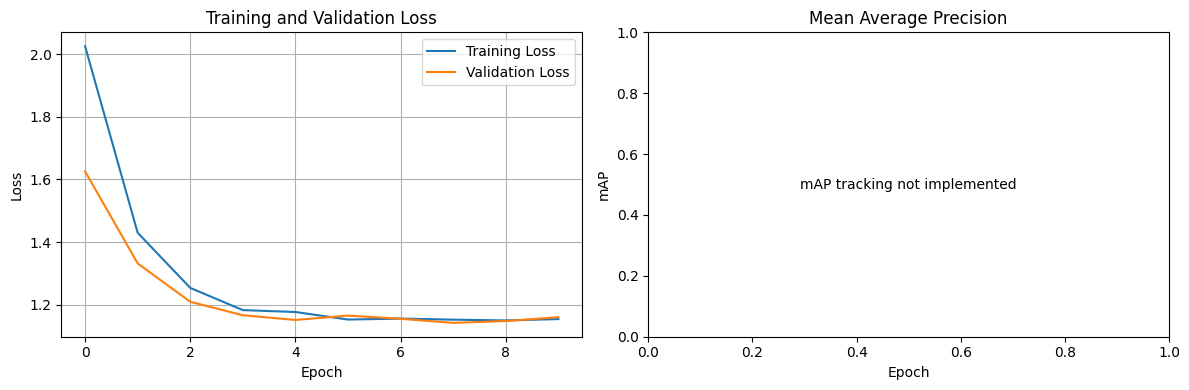

In [12]:
plot_training_curves(trainer, save_path ="models/training_curves.png")

In [13]:
model_path = wrapper.save_model(
    config=config, class_names=dataset.class_names, metrics=metrics, name="final_model"
)

print(f"\nModel saved as '{model_path}'")
print("Training curves saved as 'models/training_curves.png'")

Model saved to: models/final_model.pth

Model saved as 'models/final_model.pth'
Training curves saved as 'models/training_curves.png'


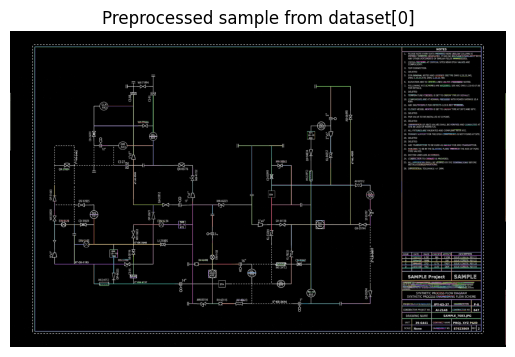

In [14]:
import matplotlib.pyplot as plt

# Grab the first sample directly
img, target = dataset[0]   # assuming your dataset returns (image, labels)

# Convert tensor [C,H,W] → numpy [H,W,C]
np_img = img.permute(1, 2, 0).numpy()
np_img = (np_img * 255).astype("uint8")

# Plot
plt.imshow(np_img)
plt.title("Preprocessed sample from dataset[0]")
plt.axis("off")
plt.show()
